# Out-of-Distribution Detection and Neural Collapse Analysis

### **Liam Loughman and Georgios Margaritis**

This project studies Out of Distribution (OOD) detection methods using a ResNet-18 model trained on CIFAR-100 (In Distribution) and tested against CIFAR-10 (Out of Distribution).

We will implement and compare several OOD scoring methods:
1. Maximum Softmax Probability (MSP)
2. MaxLogit
3. Energy Score
4. Mahalanobis Distance
5. ViM (Virtual-logit Matching)
6. NECO (Neural Collapse based OOD)

Additionally, we will analyze the Neural Collapse phenomenon during the terminal phase of training.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import itertools 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from tqdm import tqdm
import json
import warnings

warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

TRAIN = False # set to false to load trained model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Preparation

We use CIFAR-100 as the In-Distribution (ID) dataset. We apply standard data augmentations (RandomCrop, HorizontalFlip) and normalization.

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

batch_size = 128
train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

print(f"Training samples:  {len(train_dataset)}")
print(f"Test samples:      {len(test_dataset)}")
print(f"Number of classes: {100}")

Training samples:  50000
Test samples:      10000
Number of classes: 100


## 5. Out-of-Distribution Dataset

We load CIFAR-10 to serve as our Out-of-Distribution (OOD) dataset. These images are semantically different from CIFAR-100 classes but share the same image statistics (size, channels), making it a challenging benchmark.

In [3]:
ood_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

ood_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=ood_transform
)
ood_loader = torch.utils.data.DataLoader(
    ood_dataset, batch_size=batch_size, shuffle=False, num_workers=8
)

print(f"OOD samples (CIFAR-10): {len(ood_dataset)}")

OOD samples (CIFAR-10): 10000


## 2. Model Architecture

We define a ResNet-18 architecture modified for CIFAR-100. The initial convolutional layer is adjusted to handle the 32x32 input size (kernel size 3, stride 1, padding 1) compared to the standard ImageNet ResNet.

We also modify the forward pass to allow extracting features from the penultimate layer, which is necessary for Mahalanobis, ViM, and NECO methods.

In [4]:
class BasicBlock(nn.Module):
    
    """
    A standard Basic Residual Block used in ResNet architectures (e.g., ResNet-18, ResNet-34).

    This block implements the residual learning framework where the input is added to the 
    output of two stacked 3x3 convolutional layers. This skip connection helps mitigate 
    the vanishing gradient problem in deep networks. 

    The block structure is:
    Input -> Conv3x3 -> BN -> ReLU -> Conv3x3 -> BN -> (+ Input) -> ReLU

    If the input and output dimensions do not match (due to a stride > 1 or a change in 
    the number of channels), a projection shortcut (1x1 Conv + BN) is applied to the 
    input to align dimensions before addition.

    Attributes:
        expansion (int):          The expansion factor for the output channels. For BasicBlock,
        this is set to 1 (output channels = planes * expansion).
        conv1 (nn.Conv2d):        First 3x3 convolution with padding=1 and specified stride.
        bn1 (nn.BatchNorm2d):     Batch normalization for conv1.
        conv2 (nn.Conv2d):        Second 3x3 convolution with padding=1 and stride=1.
        bn2 (nn.BatchNorm2d):     Batch normalization for conv2.
        shortcut (nn.Sequential): The skip connection path. It is either an identity 
               mapping (nn.Sequential()) or a downsampling layer (1x1 Conv + BN) if 
               dimensions change.

    Args:
        in_planes (int):        Number of input channels entering the block.
        planes (int)   :        Number of output channels for the convolutional layers.
        stride (int, optional): Stride for the first convolutional layer. A stride > 1 
            is used for downsampling the spatial dimensions. Default is 1.
    """
    expansion = 1 # Expansion factor for output channels (1 for BasicBlock)

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__() # Initialize the parent nn.Module class
        
        self.conv1    = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False) # 1st 3x3 conv; handles downsampling if stride > 1
        self.bn1      = nn.BatchNorm2d(planes) # Normalize features from conv1
        self.conv2    = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # 2nd 3x3 conv; maintains spatial dimensions
        self.bn2      = nn.BatchNorm2d(planes) # Normalize features from conv2
        self.shortcut = nn.Sequential() # Initialize default identity skip connection

        if stride != 1 or in_planes != self.expansion * planes: # Check if input/output dimensions or channels mismatch
            self.shortcut = nn.Sequential( # Create projection layer to align dimensions
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False), # 1x1 conv to resize input features
                nn.BatchNorm2d(self.expansion * planes) # Normalize the projected input
            )

    def forward(self, x):
        out  = torch.relu(self.bn1(self.conv1(x))) # Apply Conv1 -> BN -> ReLU activation
        out  = self.bn2(self.conv2(out))           # Apply Conv2 -> BN (no ReLU yet)
        out += self.shortcut(x)                    # Element-wise addition of input (residual connection)
        out  = torch.relu(out)                     # Apply final ReLU after addition
        return out                                 # Return the residual block output

class ResNet(nn.Module):
    """
    A ResNet (Residual Network) architecture designed for CIFAR-100 classification.

    This implementation follows the standard ResNet design but is adapted for smaller
    input images (like CIFAR-10/100) by using a 3x3 initial convolution instead of
    the standard 7x7 convolution and max pooling used for ImageNet.

    The network consists of an initial convolutional layer followed by four stages
    (layers) of residual blocks. Each stage increases the feature channel depth
    while potentially downsampling the spatial dimensions.

    Attributes:
        in_planes (int): Tracks the number of input channels for the next block.
        conv1 (nn.Conv2d): Initial 3x3 convolution to process input images.
        bn1 (nn.BatchNorm2d): Batch normalization for the initial convolution.
        layer1 (nn.Sequential): First stage of residual blocks (64 channels).
        layer2 (nn.Sequential): Second stage (128 channels, downsample stride 2).
        layer3 (nn.Sequential): Third stage (256 channels, downsample stride 2).
        layer4 (nn.Sequential): Fourth stage (512 channels, downsample stride 2).
        linear (nn.Linear): Fully connected layer for final classification.
        features: Placeholder for storing intermediate features (unused in this code).
        penultimate_features: Stores features before the final linear layer for analysis.

    Args:
        block (class): The residual block class to use (e.g., BasicBlock, Bottleneck).
        num_blocks (list[int]): A list containing the number of blocks in each of the 4 layers.
        num_classes (int): Number of output classes for the final classification. Default is 100.
    """
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__() # Initialize parent nn.Module class
        
        self.in_planes = 64 # Initialize input channels counter for the first layer
        self.conv1  = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) # Initial 3x3 conv; adapts model for CIFAR size
        self.bn1    = nn.BatchNorm2d(64) # Normalize outputs of the first convolution
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1) # Create 1st residual layer (64 channels)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # Create 2nd residual layer (128 ch, stride 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2) # Create 3rd residual layer (256 ch, stride 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2) # Create 4th residual layer (512 ch, stride 2)
        self.linear = nn.Linear(512 * block.expansion, num_classes) # Final classifier mapping features to class scores
        
        # intermediate features for analysis
        self.features             = None # Placeholder for potential feature extraction
        self.penultimate_features = None # Placeholder to store pre-classification features

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # Define strides: first block may downsample, others don't
        layers  = [] # Initialize list to hold blocks for this layer
        for stride in strides: # Iterate through defined strides to create blocks
            layers.append(block(self.in_planes, planes, stride)) # Create block and add to list
            self.in_planes = planes * block.expansion # Update in_planes for the next block
        return nn.Sequential(*layers) # Pack list of blocks into a Sequential module

    def forward(self, x, return_features=False):
        out = torch.relu(self.bn1(self.conv1(x))) # Apply Conv1 -> BN -> ReLU
        out = self.layer1(out) # Pass through 1st residual layer
        out = self.layer2(out) # Pass through 2nd residual layer
        out = self.layer3(out) # Pass through 3rd residual layer
        out = self.layer4(out) # Pass through 4th residual layer
        out = torch.nn.functional.avg_pool2d(out, 4) # Global average pooling (4x4 -> 1x1)
        self.penultimate_features = out.view(out.size(0), -1) # Flatten and store features for OOD/NC analysis
        out = self.linear(self.penultimate_features) # Compute final class logits
        
        if return_features: # Check if feature vectors are requested
            return out, self.penultimate_features # Return both logits and features
        return out # Return only class logits

def ResNet18(num_classes=100):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes) # Instantiate ResNet-18 specific configuration

model = ResNet18(num_classes=100).to(device)

## 3. Training Loop

We train the model using SGD with momentum and Cosine Annealing learning rate scheduling. We track accuracy and loss for both training and test sets.

In [ ]:
def compute_orthodev_at_epoch(model, id_loader, ood_loader, device):
    model.eval()
    
    id_features = []
    id_labels = []
    
    with torch.no_grad():
        for i, (data, target) in enumerate(id_loader):
            data = data.to(device)
            _, features = model(data, return_features=True) 
            
            id_features.append(features)
            id_labels.append(target)
            if i > 50: break
            
    id_features = torch.cat(id_features)
    id_labels = torch.cat(id_labels).to(device)
    
    classes = torch.unique(id_labels)
    class_means = []
    for c in classes:
        mean = id_features[id_labels == c].mean(dim=0)
        class_means.append(mean)
    class_means = torch.stack(class_means)

    ood_features = []
    with torch.no_grad():
        for i, (data, _) in enumerate(ood_loader):
            data = data.to(device)
            _, features = model(data, return_features=True)
            ood_features.append(features)
            if i > 50: break 
            
    ood_features = torch.cat(ood_features)
    global_ood_mean = ood_features.mean(dim=0)
    
    class_means_norm = torch.nn.functional.normalize(class_means, p=2, dim=1)
    global_ood_mean_norm = torch.nn.functional.normalize(global_ood_mean.unsqueeze(0), p=2, dim=1)
    
    cos_sim = torch.mm(class_means_norm, global_ood_mean_norm.t())
    orthodev = torch.abs(cos_sim).mean().item()
    
    return orthodev

def train_model(model, train_loader, test_loader, ood_loader, epochs=350, lr=0.1): 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) 
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    orthodev_history = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': running_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        scheduler.step()
        
        print(f"Epoch {epoch+1}: Computing NC5...")

        current_orthodev = compute_orthodev_at_epoch(model, train_loader, ood_loader, device) 
        orthodev_history.append(current_orthodev)
        print(f"Epoch {epoch+1} NC5: {current_orthodev:.4f}")
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    np.save('nc5_history.npy', orthodev_history)
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    }

In [6]:
if TRAIN:
    print("Starting training")
    training_results = train_model(model, train_loader, test_loader, ood_loader, epochs=350, lr=0.1)
    torch.save(model.state_dict(), 'resnet18_cifar100.pth')
    print("Model saved to resnet18_cifar100.pth")
    json.dump(training_results, open('training_results.json', 'w'))

else:
    path = 'resnet18_cifar100.pth'
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"Model successfully loaded from {path}")

Model successfully loaded from resnet18_cifar100.pth


# Plotting the NECO Graph 

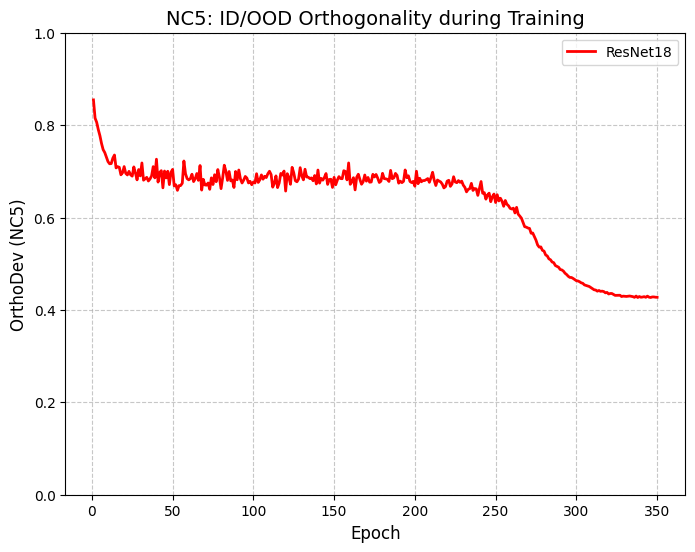

In [ ]:
plt.figure(figsize=(8, 6))
orthodev_history = np.load('nc5_history.npy').tolist() 
plt.plot(range(1, len(orthodev_history) + 1), orthodev_history, linewidth=2, color='red', label='ResNet18')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('OrthoDev (NC5)', fontsize=12)
plt.title('NC5: ID/OOD Orthogonality during Training', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(0, 1.0) 
plt.show()

## 4. Training Visualization

We visualize the loss and accuracy curves to ensure the model has converged. For Neural Collapse to emerge, the model ideally needs to reach near-zero training error (Terminal Phase of Training).

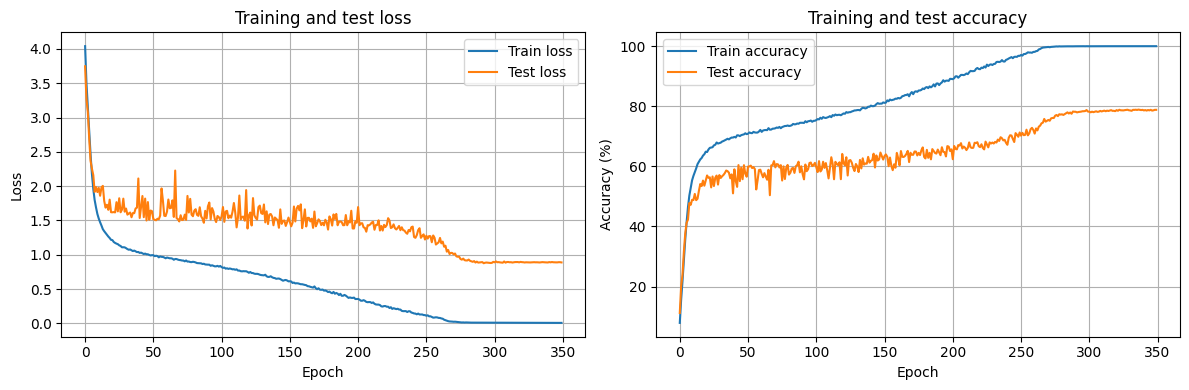

Final test accuracy: 78.80%


In [8]:
if TRAIN == False:
    training_results = json.load(open('training_results.json', 'r'))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(training_results['train_losses'], label='Train loss')
axes[0].plot(training_results['test_losses'], label='Test loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and test loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(training_results['train_accs'], label='Train accuracy')
axes[1].plot(training_results['test_accs'], label='Test accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and test accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Final test accuracy: {training_results['test_accs'][-1]:.2f}%")

## 6. OOD Scoring Methods implementation

We implement the following scoring functions:
- **MSP:** Uses softmax confidence.
- **MaxLogit:** Uses raw logits to avoid softmax saturation.
- **Energy:** Uses the LogSumExp of logits.
- **Mahalanobis:** Calculates distance to class centroids in feature space.
- **ViM:** Combines logits with the residual norm in the principal subspace.

In [9]:
def compute_msp_score(model, dataloader):
    """Maximum Softmax Probability (MSP) score"""
    model.eval()
    scores = []
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, _ = probabilities.max(dim=1)
            scores.extend(max_probs.cpu().numpy())
    
    return np.array(scores)

def compute_max_logit_score(model, dataloader):
    """Maximum Logit score"""
    model.eval()
    scores = []
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            max_logits, _ = outputs.max(dim=1)
            scores.extend(max_logits.cpu().numpy())
    
    return np.array(scores)

def compute_energy_score(model, dataloader, temperature=1.0):
    """Energy based score"""
    model.eval()
    scores = []
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs  = inputs.to(device)
            outputs = model(inputs) / temperature
            energy  = -temperature * torch.logsumexp(outputs, dim=1)
            scores.extend(energy.cpu().numpy())
    
    return np.array(scores)

def compute_mahalanobis_score(model, train_loader, dataloader):
    """Mahalanobis distance based score"""
    model.eval()
    
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            _, feat = model(inputs, return_features=True)
            features.append(feat.cpu().numpy())
            labels.append(targets.numpy())
    
    features = np.vstack(features)
    labels   = np.concatenate(labels)
    
    class_means = []
    for c in range(100):
        class_mask = labels == c
        if np.sum(class_mask) > 0:
            class_means.append(features[class_mask].mean(axis=0))
        else:
            class_means.append(np.zeros(features.shape[1]))
    
    class_means = np.array(class_means)
    
    cov = EmpiricalCovariance(assume_centered=False)
    cov.fit(features - class_means[labels])
    
    scores = []
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            _, feat = model(inputs, return_features=True)
            feat_np = feat.cpu().numpy()
            
            dists = []
            for f in feat_np:
                diff = class_means - f
                mahalanobis_dists = np.diag(diff @ cov.precision_ @ diff.T)
                dists.append(mahalanobis_dists.min())
            
            scores.extend(dists)
    
    return np.array(scores)

def compute_vim_score(model, train_loader, dataloader, d=512):
    """Virtual Logit Matching (ViM) score"""
    model.eval()
    
    train_features = []
    train_logits = []
    
    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            logits, feat = model(inputs, return_features=True)
            train_features.append(feat.cpu().numpy())
            train_logits.append(logits.cpu().numpy())
    
    train_features = np.vstack(train_features)
    train_logits   = np.vstack(train_logits)
    
    pca = PCA(n_components=d, whiten=True)
    pca.fit(train_features)

    train_pca      = pca.transform(train_features)
    train_recon    = pca.inverse_transform(train_pca)
    train_residual = np.linalg.norm(train_features - train_recon, axis=1)
    alpha = train_logits.max(axis=1).mean() / train_residual.mean()
    
    scores = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            logits, feat = model(inputs, return_features=True)
            feat_np = feat.cpu().numpy()
            logits_np = logits.cpu().numpy()

            feat_pca = pca.transform(feat_np)
            feat_recon = pca.inverse_transform(feat_pca)
            residual = feat_np - feat_recon
            v_logit = np.linalg.norm(residual, axis=1)

            energy = np.log(np.sum(np.exp(logits_np), axis=1))
            
            # vim_scores = alpha * v_logit - energy 
            vim_scores = energy - alpha * v_logit
            scores.extend(vim_scores)
    
    return np.array(scores)

## 7. Computing Scores

We compute the OOD scores for both the In-Distribution test set (CIFAR-100) and the Out-of-Distribution dataset (CIFAR-10).

In [10]:
print("Computing OOD scores for ID data (CIFAR-100 test)...")
id_scores = {}

# ID data
id_scores['msp']         = compute_msp_score(model, test_loader)
id_scores['max_logit']   = compute_max_logit_score(model, test_loader)
id_scores['energy']      = compute_energy_score(model, test_loader, temperature=1.0)
id_scores['mahalanobis'] = compute_mahalanobis_score(model, train_loader, test_loader)
id_scores['vim']         = compute_vim_score(model, train_loader, test_loader, d=512)

print("Computing OOD scores for OOD data (CIFAR-10)...")
ood_scores = {}

# OOD data
ood_scores['msp']         = compute_msp_score(model, ood_loader)
ood_scores['max_logit']   = compute_max_logit_score(model, ood_loader)
ood_scores['energy']      = compute_energy_score(model, ood_loader, temperature=1.0)
ood_scores['mahalanobis'] = compute_mahalanobis_score(model, train_loader, ood_loader)
ood_scores['vim']         = compute_vim_score(model, train_loader, ood_loader, d=512)

Computing OOD scores for ID data (CIFAR-100 test)...
Computing OOD scores for OOD data (CIFAR-10)...


## 8. Performance Evaluation

We evaluate the methods using:
1. **AUROC:** Area Under the Receiver Operating Characteristic curve. Higher is better.
2. **FPR @ 95% TPR:** False Positive Rate when True Positive Rate is 95%. Lower is better.

In [ ]:
def compute_auroc(id_scores, ood_scores):
    """Compute AUROC score"""
    scores = np.concatenate([id_scores, ood_scores])
    labels = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
    return roc_auc_score(labels, scores)

def compute_fpr_at_95_tpr(id_scores, ood_scores):
    """Compute FPR at 95% TPR (Higher score = OOD)"""
    threshold = np.percentile(id_scores, 95)
    fpr = np.mean(ood_scores <= threshold)
    return fpr

methods = ['msp', 'max_logit', 'energy', 'mahalanobis', 'vim']
results = []

for method in methods:
    scores_id = id_scores[method]
    scores_ood = ood_scores[method]

    if method in ['msp', 'max_logit', 'vim']:
        scores_id = -scores_id
        scores_ood = -scores_ood
    
    auroc = compute_auroc(scores_id, scores_ood)
    fpr95 = compute_fpr_at_95_tpr(scores_id, scores_ood)
    
    results.append({
        'Method': method.upper(),
        'AUROC': auroc,
        'FPR@95%TPR': fpr95
    })
    

results_df = pd.DataFrame(results)
print("\nOOD Detection Performance Comparison:")
print(results_df.to_string(index=False))


OOD Detection Performance Comparison:
     Method    AUROC  FPR@95%TPR
        MSP 0.819017      0.7503
  MAX_LOGIT 0.824240      0.7452
     ENERGY 0.824609      0.7496
MAHALANOBIS 0.744586      0.8585
        VIM 0.742314      0.9037


## 9. Score Distributions

We visualize the histograms of scores for ID and OOD data. A good OOD detector should show minimal overlap between the two distributions.

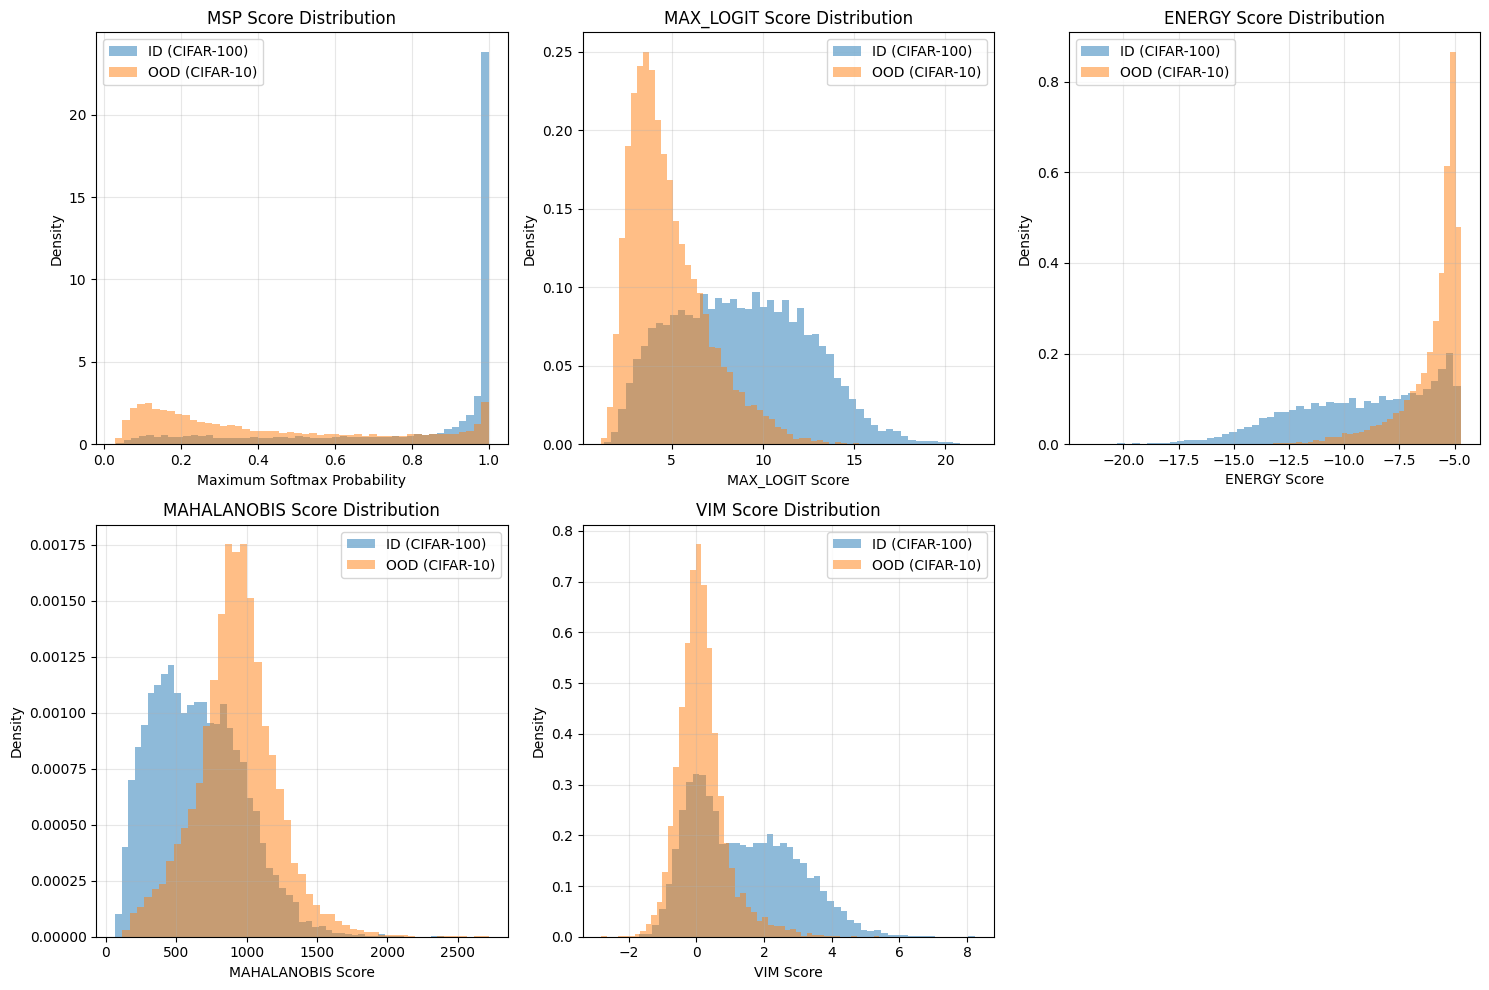

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, method in enumerate(methods):
    ax = axes[idx]
    
    if method in ['msp']:
        ax.hist(id_scores[method], bins=50, alpha=0.5, label='ID (CIFAR-100)', density=True)
        ax.hist(ood_scores[method], bins=50, alpha=0.5, label='OOD (CIFAR-10)', density=True)
        ax.set_xlabel('Maximum Softmax Probability')
    else:
        ax.hist(id_scores[method], bins=50, alpha=0.5, label='ID (CIFAR-100)', density=True)
        ax.hist(ood_scores[method], bins=50, alpha=0.5, label='OOD (CIFAR-10)', density=True)
        ax.set_xlabel(method.upper() + ' Score')
    
    ax.set_ylabel('Density')
    ax.set_title(f'{method.upper()} Score Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 10. Neural Collapse Analysis

We calculate the four key properties of Neural Collapse (NC) that emerge during the terminal phase of training:
- **NC1:** Variability collapse (features contract to class means).
- **NC2:** Convergence to Equiangular Tight Frame (Simplex ETF).
- **NC3:** Self-duality (alignment of classifier weights and class means).
- **NC4:** Simplification to Nearest Class Center (NCC) classifier.

In [13]:
def compute_neural_collapse_metrics(model, dataloader):
    """Compute Neural Collapse metrics (NC1-NC4)"""
    model.eval()
    
    all_features = []
    all_labels   = []
    all_logits   = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits, features = model(inputs, return_features=True)
            
            all_features.append(features.cpu().numpy())
            all_labels.append(targets.cpu().numpy())
            all_logits.append(logits.cpu().numpy())
    
    features = np.vstack(all_features)
    labels   = np.concatenate(all_labels)
    logits   = np.vstack(all_logits)
    
    num_classes = 100
    
    class_means = []
    within_class_vars = []
    
    for c in range(num_classes):
        class_mask = labels == c
        if np.sum(class_mask) > 1:
            class_feats = features[class_mask]
            class_mean  = class_feats.mean(axis=0)
            class_var   = np.mean(np.linalg.norm(class_feats - class_mean, axis=1)**2)
            class_means.append(class_mean)
            within_class_vars.append(class_var)
    
    class_means = np.array(class_means)
    within_class_vars = np.array(within_class_vars)
    
    global_mean = class_means.mean(axis=0)
    between_class_var = np.mean(np.linalg.norm(class_means - global_mean, axis=1)**2)
    within_class_var = np.mean(within_class_vars)
    nc1 = within_class_var / (between_class_var + 1e-8)
    
    normalized_means = class_means / np.linalg.norm(class_means, axis=1, keepdims=True)
    
    cosine_sim_matrix = normalized_means @ normalized_means.T
    np.fill_diagonal(cosine_sim_matrix, 0)
    
    ideal_cosine = -1 / (num_classes - 1)
    nc2 = np.mean((cosine_sim_matrix - ideal_cosine)**2)
    
    classifier_weights = model.linear.weight.data.cpu().numpy()
    
    norm_classifier = classifier_weights / np.linalg.norm(classifier_weights, axis=1, keepdims=True)
    norm_means = class_means / np.linalg.norm(class_means, axis=1, keepdims=True)
    
    alignment_matrix = norm_classifier @ norm_means.T
    nc3 = 1 - np.mean(np.diag(alignment_matrix))
    
    correct_ncc = 0
    total_ncc = 0
    
    for c in range(num_classes):
        class_mask = labels == c
        if np.sum(class_mask) > 0:
            class_feats = features[class_mask]
            
            distances   = np.linalg.norm(class_feats[:, np.newaxis] - class_means, axis=2)
            predictions = np.argmin(distances, axis=1)
            
            correct_ncc += np.sum(predictions == c)
            total_ncc += len(class_feats)
    
    ncc_accuracy = correct_ncc / total_ncc if total_ncc > 0 else 0
    
    predictions = np.argmax(logits, axis=1)
    standard_accuracy = np.mean(predictions == labels)
    
    nc4 = standard_accuracy - ncc_accuracy
    
    return {
        'NC1': nc1,
        'NC2': nc2,
        'NC3': nc3,
        'NC4': nc4,
        'class_means': class_means,
        'within_class_vars': within_class_vars,
        'features': features,
        'labels': labels,
        'ncc_accuracy': ncc_accuracy,
        'standard_accuracy': standard_accuracy
    }

In [14]:
print("Computing Neural Collapse metrics...")
nc_metrics = compute_neural_collapse_metrics(model, test_loader)

print("\nNeural Collapse Metrics:")
print(f"NC1 (Variability Collapse): {nc_metrics['NC1']:.6f}")
print(f"NC2 (ETF Convergence):      {nc_metrics['NC2']:.6f}")
print(f"NC3 (Self-Duality):         {nc_metrics['NC3']:.6f}")
print(f"NC4 (Nearest Center):       {nc_metrics['NC4']:.6f}")
print(f"Standard Accuracy:          {nc_metrics['standard_accuracy']*100:.2f}%")
print(f"NCC Accuracy:               {nc_metrics['ncc_accuracy']*100:.2f}%")

Computing Neural Collapse metrics...

Neural Collapse Metrics:
NC1 (Variability Collapse): 0.506205
NC2 (ETF Convergence):      0.105466
NC3 (Self-Duality):         0.203659
NC4 (Nearest Center):       0.004300
Standard Accuracy:          78.80%
NCC Accuracy:               78.37%


# Visualizing orthogonality NC5


In [ ]:
def visualize_centroid_vectors_only(model, id_loader, ood_loader, device, num_id_classes=5, num_samples_for_centroid=100):
    """
    Visualizes ONLY the centroid vectors for a specified number of ID classes and the OOD dataset.
    Centroids are computed using a random sample of the features.
    
    Args:
        model:          The trained neural network.
        id_loader:      DataLoader for the In-Distribution data.
        ood_loader:     DataLoader for the Out-of-Distribution data.
        device:         'cuda' or 'cpu'.
        num_id_classes: Number of ID classes to visualize.
        num_samples_for_centroid: Number of random samples to draw per class to compute its centroid.
    """
    model.eval()
    id_features_list = []
    id_labels_list = []
    ood_features_list = []
    
    print("Extracting features from the penultimate layer...")
    with torch.no_grad(): 
        
        for inputs, targets in id_loader:
            inputs = inputs.to(device)
            _, feats = model(inputs, return_features=True)
            id_features_list.append(feats.cpu().numpy())
            id_labels_list.append(targets.numpy())
            
        id_features = np.vstack(id_features_list)
        id_labels = np.concatenate(id_labels_list)
        
        for inputs, _ in ood_loader:
            inputs = inputs.to(device)
            _, feats = model(inputs, return_features=True)
            ood_features_list.append(feats.cpu().numpy())
            if len(ood_features_list) * inputs.size(0) > num_samples_for_centroid * num_id_classes * 2:
                break
                
        ood_features = np.vstack(ood_features_list)
        
    print(f"Randomly sampling {num_samples_for_centroid} points per class for {num_id_classes} classes...")
    
    all_classes      = np.unique(id_labels)
    selected_classes = all_classes[:num_id_classes] 
    
    sampled_id_features = []
    sampled_id_labels   = []
    
    for cls in selected_classes:
        cls_mask  = (id_labels == cls)
        cls_feats = id_features[cls_mask]
        
        n_samples = min(num_samples_for_centroid, len(cls_feats))
        random_indices = np.random.choice(len(cls_feats), n_samples, replace=False)
        
        sampled_id_features.append(cls_feats[random_indices])
        sampled_id_labels.extend([cls] * n_samples)
        
    sampled_id_features = np.vstack(sampled_id_features)
    sampled_id_labels = np.array(sampled_id_labels)


    n_ood_samples = min(num_samples_for_centroid * num_id_classes, len(ood_features))
    ood_random_indices = np.random.choice(len(ood_features), n_ood_samples, replace=False)
    sampled_ood_features = ood_features[ood_random_indices]

    print("Computing 3D PCA and generating centroids...")
  
    combined_features = np.vstack([sampled_id_features, sampled_ood_features])
    pca = PCA(n_components=3)
    pca.fit(combined_features)
    
    id_pca  = pca.transform(sampled_id_features)
    ood_pca = pca.transform(sampled_ood_features)
    
    global_origin = np.mean(pca.transform(combined_features), axis=0)
    ood_centroid  = ood_pca.mean(axis=0)
    
    ood_vector = ood_centroid - global_origin
    scale_factor = 3.5  
    scaled_ood_end = global_origin + (ood_vector * scale_factor)

    print("Rendering Interactive 3D Plot...")
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=[ood_centroid[0]], y=[ood_centroid[1]], z=[ood_centroid[2]],
        mode='markers+text',
        marker=dict(size=8, color='black', symbol='cross'),
        text=['OOD Mean'], textposition="top center",
        name='OOD Centroid'
    ))

    fig.add_trace(go.Scatter3d(
        x=[global_origin[0], scaled_ood_end[0]],
        y=[global_origin[1], scaled_ood_end[1]],
        z=[global_origin[2], scaled_ood_end[2]],
        mode='lines',
        line=dict(color='black', width=17),
        name='OOD Vector Direction'
    ))

    colors = px.colors.qualitative.Plotly
    for i, cls in enumerate(selected_classes):
        cls_mask = (sampled_id_labels == cls)
        cls_pca = id_pca[cls_mask]
        
        cls_centroid = cls_pca.mean(axis=0)
        color = colors[i % len(colors)]
        
        fig.add_trace(go.Scatter3d(
            x=[cls_centroid[0]], y=[cls_centroid[1]], z=[cls_centroid[2]],
            mode='markers+text',
            marker=dict(size=6, color=color, symbol='diamond'),
            text=[f'Class {cls}'], textposition="top center",
            name=f'Centroid Class {cls}'
        ))
        
        fig.add_trace(go.Scatter3d(
            x=[global_origin[0], cls_centroid[0]],
            y=[global_origin[1], cls_centroid[1]],
            z=[global_origin[2], cls_centroid[2]],
            mode='lines',
            line=dict(color=color, width=3),
            name=f'Vector Class {cls}'
        ))
    
    fig.update_layout(
    title=f"Centroid Vectors: {num_id_classes} ID Classes vs OOD (Sampled with {num_samples_for_centroid} pts)",
    scene=dict(
        xaxis_title='P_C 1',
        yaxis_title='P_C 2',
        zaxis_title='P_C 3',
        aspectmode='cube',
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            showbackground=False         
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            showbackground=False
        ),
        zaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            showbackground=False
        )
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(x=1.05, y=0.5),
    showlegend=False,
    autosize=True
)
    fig.show(config={'responsive': True})  

In [16]:
visualize_centroid_vectors_only(model, test_loader, ood_loader, device, num_id_classes=20, num_samples_for_centroid=100)

Extracting features from the penultimate layer...
Randomly sampling 100 points per class for 20 classes...
Computing 3D PCA and generating centroids...
Rendering Interactive 3D Plot...


## 11. Visualizing Neural Collapse

We visualize the feature space using PCA, the cosine similarity of class means, and the alignment between weights and features.

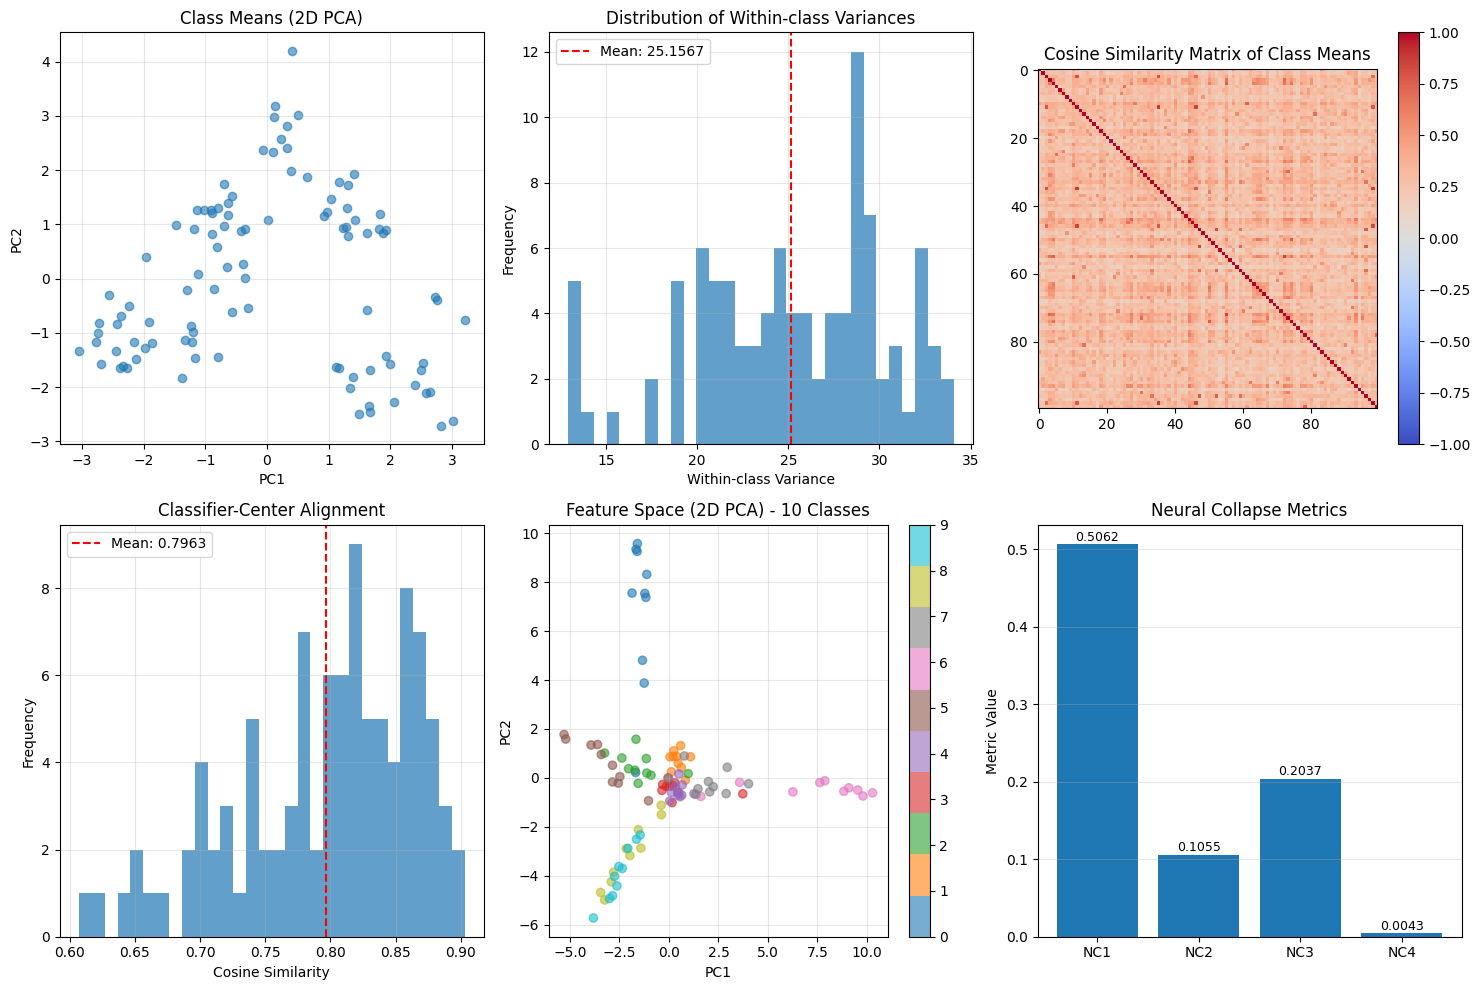

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

class_means = nc_metrics['class_means']
pca = PCA(n_components=2)
means_2d = pca.fit_transform(class_means)

axes[0, 0].scatter(means_2d[:, 0], means_2d[:, 1], alpha=0.6)
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].set_title('Class Means (2D PCA)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(nc_metrics['within_class_vars'], bins=30, alpha=0.7)
axes[0, 1].set_xlabel('Within-class Variance')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Within-class Variances')
axes[0, 1].axvline(np.mean(nc_metrics['within_class_vars']), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(nc_metrics["within_class_vars"]):.4f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

normalized_means = class_means / np.linalg.norm(class_means, axis=1, keepdims=True)
cosine_sim = normalized_means @ normalized_means.T

im = axes[0, 2].imshow(cosine_sim, cmap='coolwarm', vmin=-1, vmax=1)
axes[0, 2].set_title('Cosine Similarity Matrix of Class Means')
plt.colorbar(im, ax=axes[0, 2])

classifier_weights = model.linear.weight.data.cpu().numpy()
norm_classifier = classifier_weights / np.linalg.norm(classifier_weights, axis=1, keepdims=True)
norm_means = class_means / np.linalg.norm(class_means, axis=1, keepdims=True)
alignment = np.diag(norm_classifier @ norm_means.T)

axes[1, 0].hist(alignment, bins=30, alpha=0.7)
axes[1, 0].set_xlabel('Cosine Similarity')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Classifier-Center Alignment')
axes[1, 0].axvline(np.mean(alignment), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(alignment):.4f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

sampled_features = []
sampled_labels = []
for c in range(min(10, 100)):
    class_mask = nc_metrics['labels'] == c
    if np.sum(class_mask) > 10:
        class_feats = nc_metrics['features'][class_mask][:10]
        sampled_features.append(class_feats)
        sampled_labels.extend([c] * 10)

if sampled_features:
    sampled_features = np.vstack(sampled_features)
    pca_features = PCA(n_components=2).fit_transform(sampled_features)
    
    scatter = axes[1, 1].scatter(pca_features[:, 0], pca_features[:, 1], 
                                 c=sampled_labels, cmap='tab10', alpha=0.6)
    axes[1, 1].set_xlabel('PC1')
    axes[1, 1].set_ylabel('PC2')
    axes[1, 1].set_title('Feature Space (2D PCA) - 10 Classes')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 1])

nc_values = [nc_metrics['NC1'], nc_metrics['NC2'], nc_metrics['NC3'], nc_metrics['NC4']]
nc_names = ['NC1', 'NC2', 'NC3', 'NC4']

bars = axes[1, 2].bar(nc_names, nc_values)
axes[1, 2].set_ylabel('Metric Value')
axes[1, 2].set_title('Neural Collapse Metrics')
axes[1, 2].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, nc_values):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, height + 0.001,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 12. NECO: Neural Collapse Based OOD

We implement NECO, which leverages the structural properties of Neural Collapse. It measures how well a sample projects onto the principal subspace of the ID features, scaled by the maximum logit.

In [ ]:
def compute_neco_score(model, train_loader, dataloader, d=100):
    """Compute NECO (Neural Collapse) based OOD score"""
    model.eval()
    
    train_features = []
    
    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            _, feat = model(inputs, return_features=True)
            train_features.append(feat.cpu().numpy())
    
    train_features = np.vstack(train_features)
    scaler = StandardScaler()
    train_features_std = scaler.fit_transform(train_features)
    pca = PCA(n_components=train_features_std.shape[1]) 
    pca.fit(train_features_std)
    
    scores = []
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            logits, feat = model(inputs, return_features=True)
            feat_np = feat.cpu().numpy()
            feat_std = scaler.transform(feat_np)
            feat_pca = pca.transform(feat_std)[:, :d] 
            norm_pca = np.linalg.norm(feat_pca, axis=1)
            norm_std = np.linalg.norm(feat_std, axis=1)
            neco_scores = norm_pca / (norm_std + 1e-10)
            scores.extend(neco_scores)
    
    return np.array(scores)

print("Computing NECO scores...")

neco_id  = compute_neco_score(model, train_loader, test_loader, d=100)
neco_ood = compute_neco_score(model, train_loader, ood_loader, d=100)
neco_auroc = compute_auroc(-neco_id, -neco_ood)
neco_fpr95 = compute_fpr_at_95_tpr(-neco_id, -neco_ood)

print(f"\nNECO Performance:")
print(f"AUROC: {neco_auroc:.4f}")
print(f"FPR@95%TPR: {neco_fpr95:.4f}")

results.append({
    'Method': 'NECO',
    'AUROC': neco_auroc,
    'FPR@95%TPR': neco_fpr95
})

results_df = pd.DataFrame(results)
print("\nUpdated OOD Detection Performance Comparison:")
print(results_df.to_string(index=False))

Computing NECO scores...

NECO Performance:
AUROC: 0.7612
FPR@95%TPR: 0.7937

Updated OOD Detection Performance Comparison:
     Method    AUROC  FPR@95%TPR
        MSP 0.819017      0.7503
  MAX_LOGIT 0.824240      0.7452
     ENERGY 0.824609      0.7496
MAHALANOBIS 0.744586      0.8585
        VIM 0.742314      0.9037
       NECO 0.761178      0.7937


## 13. NECO Visualization

We compare NECO against other methods and visualize the correlation between NECO scores and MaxLogit scores.

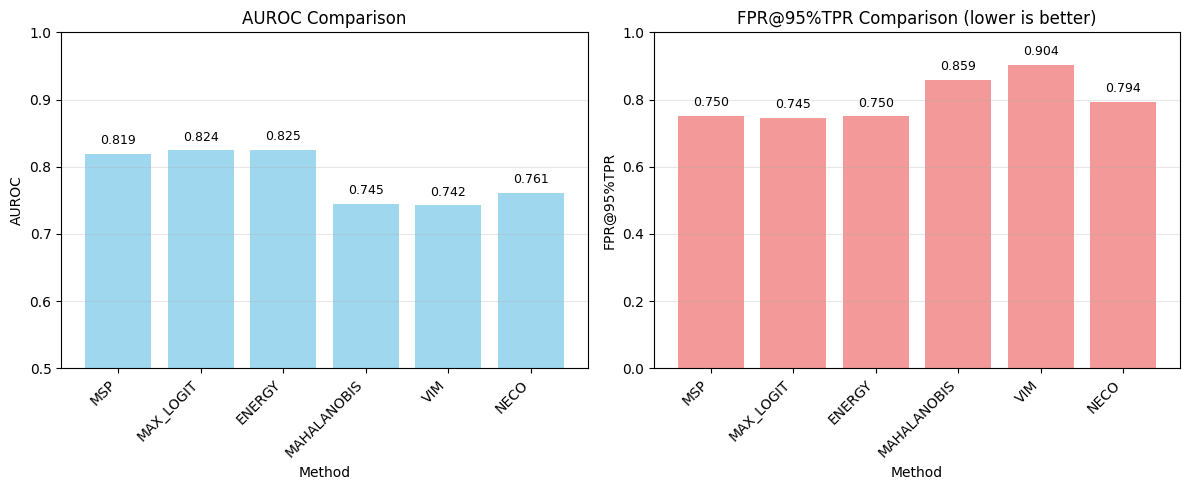

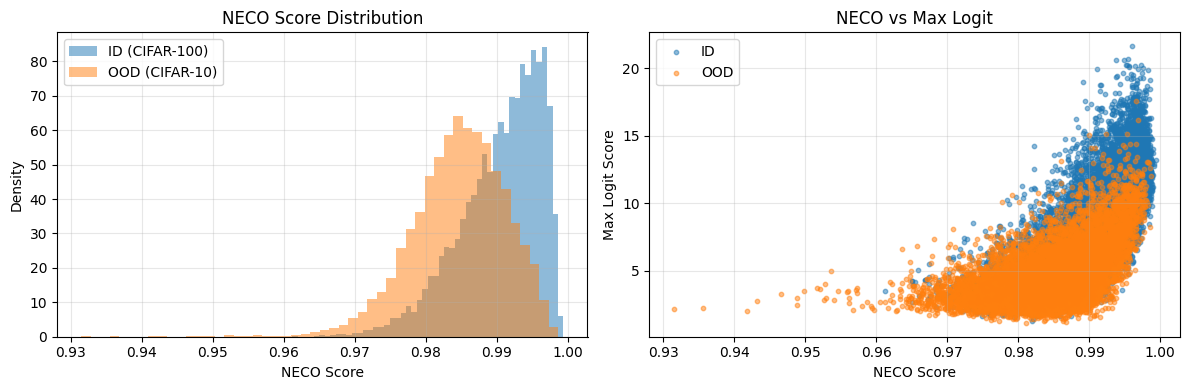

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

methods_clean = [r['Method'] for r in results]
aurocs = [r['AUROC'] for r in results]
fprs = [r['FPR@95%TPR'] for r in results]

x_pos = np.arange(len(methods_clean))
axes[0].bar(x_pos, aurocs, color='skyblue', alpha=0.8)
axes[0].set_xlabel('Method')
axes[0].set_ylabel('AUROC')
axes[0].set_title('AUROC Comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(methods_clean, rotation=45, ha='right')
axes[0].set_ylim([0.5, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(aurocs):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

axes[1].bar(x_pos, fprs, color='lightcoral', alpha=0.8)
axes[1].set_xlabel('Method')
axes[1].set_ylabel('FPR@95%TPR')
axes[1].set_title('FPR@95%TPR Comparison (lower is better)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(methods_clean, rotation=45, ha='right')
axes[1].set_ylim([0, 1.0])
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(fprs):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(neco_id, bins=50, alpha=0.5, label='ID (CIFAR-100)', density=True)
axes[0].hist(neco_ood, bins=50, alpha=0.5, label='OOD (CIFAR-10)', density=True)
axes[0].set_xlabel('NECO Score')
axes[0].set_ylabel('Density')
axes[0].set_title('NECO Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(neco_id, id_scores['max_logit'], alpha=0.5, label='ID', s=10)
axes[1].scatter(neco_ood, ood_scores['max_logit'], alpha=0.5, label='OOD', s=10)
axes[1].set_xlabel('NECO Score')
axes[1].set_ylabel('Max Logit Score')
axes[1].set_title('NECO vs Max Logit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Layer-wise Analysis

We investigate how Neural Collapse (specifically NC1) evolves across the layers of the network. We expect the variability collapse to be more pronounced in deeper layers.

Analyzing Neural Collapse across layers...
layer1: NC1 = 3.952572
layer2: NC1 = 3.702934
layer3: NC1 = 3.213995
layer4: NC1 = 0.485522
penultimate: NC1 = 0.344406


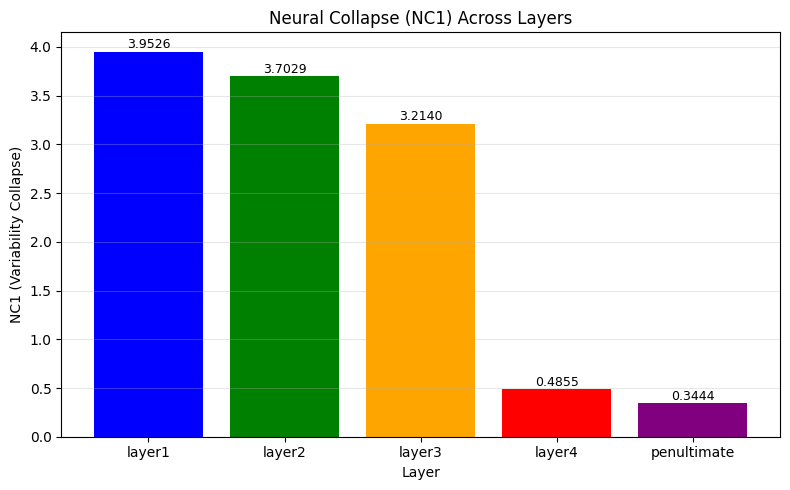

In [ ]:
def extract_layer_features(model, dataloader, layer_names):
    """Extract features from multiple layers"""
    model.eval()
    
    features = {name: [] for name in layer_names}
    labels = []
    
    def get_hook(name):
        def hook(module, input, output):
            features[name].append(output.detach().cpu().numpy())
        return hook
    
    hooks = []
    for name in layer_names:
        if name == 'layer1':
            hook = model.layer1.register_forward_hook(get_hook(name))
        elif name == 'layer2':
            hook = model.layer2.register_forward_hook(get_hook(name))
        elif name == 'layer3':
            hook = model.layer3.register_forward_hook(get_hook(name))
        elif name == 'layer4':
            hook = model.layer4.register_forward_hook(get_hook(name))
        elif name == 'penultimate':
            def penultimate_hook(module, input, output):
                features[name].append(output.detach().cpu().numpy())
            hook = model.linear.register_forward_hook(penultimate_hook)
        hooks.append(hook)
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            _ = model(inputs)
            labels.append(targets.numpy())
    
    for hook in hooks:
        hook.remove()
    
    for name in features:
        if features[name]:
            features[name] = np.vstack(features[name])
    
    labels = np.concatenate(labels)
    
    return features, labels

def compute_layer_nc1(features, labels, num_classes=100):
    """Compute NC1 metric for features from a specific layer"""
    if len(features.shape) > 2:
        features = features.reshape(features.shape[0], -1)
    
    class_means = []
    within_class_vars = []
    
    for c in range(num_classes):
        class_mask = labels == c
        if np.sum(class_mask) > 1:
            class_feats = features[class_mask]
            class_mean = class_feats.mean(axis=0)
            class_var = np.mean(np.linalg.norm(class_feats - class_mean, axis=1)**2)
            
            class_means.append(class_mean)
            within_class_vars.append(class_var)
    
    if not class_means:
        return np.nan
    
    class_means       = np.array(class_means)
    within_class_vars = np.array(within_class_vars)
    
    global_mean       = class_means.mean(axis=0)
    between_class_var = np.mean(np.linalg.norm(class_means - global_mean, axis=1)**2)
    within_class_var  = np.mean(within_class_vars)
    
    return within_class_var / (between_class_var + 1e-8)

print("Analyzing Neural Collapse across layers...")

for module in model.modules():
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()

layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'penultimate']
subset_loader = itertools.islice(test_loader, 5) 
layer_features, layer_labels = extract_layer_features(model, subset_loader, layer_names)

layer_nc1 = {}
for layer in layer_names:
    if layer in layer_features:
        nc1 = compute_layer_nc1(layer_features[layer], layer_labels)
        layer_nc1[layer] = nc1
        print(f"{layer}: NC1 = {nc1:.6f}")

fig, ax = plt.subplots(figsize=(8, 5))
layers = list(layer_nc1.keys())
nc1_values = list(layer_nc1.values())

bars = ax.bar(layers, nc1_values, color=['blue', 'green', 'orange', 'red', 'purple'])
ax.set_xlabel('Layer')
ax.set_ylabel('NC1 (Variability Collapse)')
ax.set_title('Neural Collapse (NC1) Across Layers')
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, nc1_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.001,
            f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

layer1: Effective Dim (95% Var) = 530
layer2: Effective Dim (95% Var) = 535
layer3: Effective Dim (95% Var) = 538
layer4: Effective Dim (95% Var) = 134
penultimate: Effective Dim (95% Var) = 57


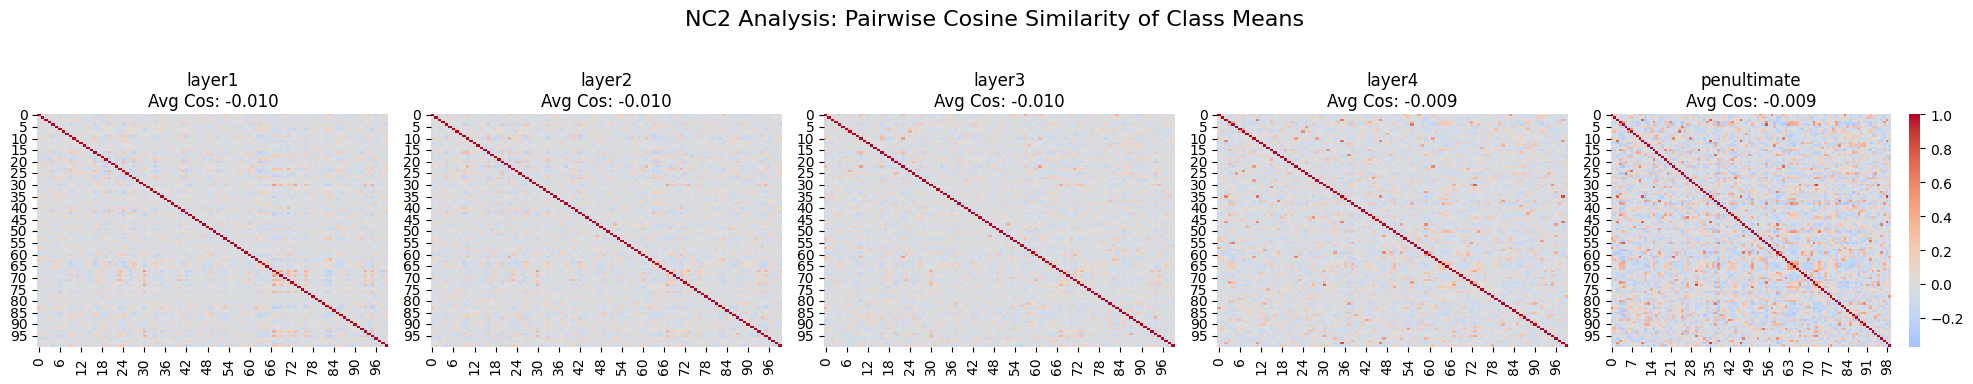

In [ ]:
def compute_nc2_metrics(features, labels, num_classes=100):
    """Compute NC2: Equiangularity of class means"""
    if len(features.shape) > 2:
        features = features.reshape(features.shape[0], -1)

    class_means = []
    for c in range(num_classes):
        mask = (labels == c)
        if np.sum(mask) > 0:
            class_means.append(features[mask].mean(axis=0))
    
    mu_c = np.array(class_means) 
    mu_G = mu_c.mean(axis=0)
    centered_means = mu_c - mu_G

    norms = np.linalg.norm(centered_means, axis=1, keepdims=True)
    normalized_means = centered_means / (norms + 1e-8)
  
    cosine_mat = np.matmul(normalized_means, normalized_means.T)

    mask = ~np.eye(cosine_mat.shape[0], dtype=bool)
    off_diag_values = cosine_mat[mask]
    
    return cosine_mat, off_diag_values

def analyze_layer_geometry(layer_features, layer_labels, num_classes=100):
    layers = list(layer_features.keys())
    
    fig, axes = plt.subplots(1, len(layers), figsize=(20, 4))
    fig.suptitle("NC2 Analysis: Pairwise Cosine Similarity of Class Means", fontsize=16)
    
    for i, name in enumerate(layers):
        feat = layer_features[name]
        cosine_mat, off_diag = compute_nc2_metrics(feat, layer_labels, num_classes)
        
        sns.heatmap(cosine_mat, ax=axes[i], cmap='coolwarm', center=0, cbar=(i == len(layers)-1))
        axes[i].set_title(f"{name}\nAvg Cos: {off_diag.mean():.3f}")
        if len(feat.shape) > 2: feat = feat.reshape(feat.shape[0], -1)
        pca = PCA().fit(feat)
        dim_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
        print(f"{name}: Effective Dim (95% Var) = {dim_95}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

analyze_layer_geometry(layer_features, layer_labels, num_classes=100)

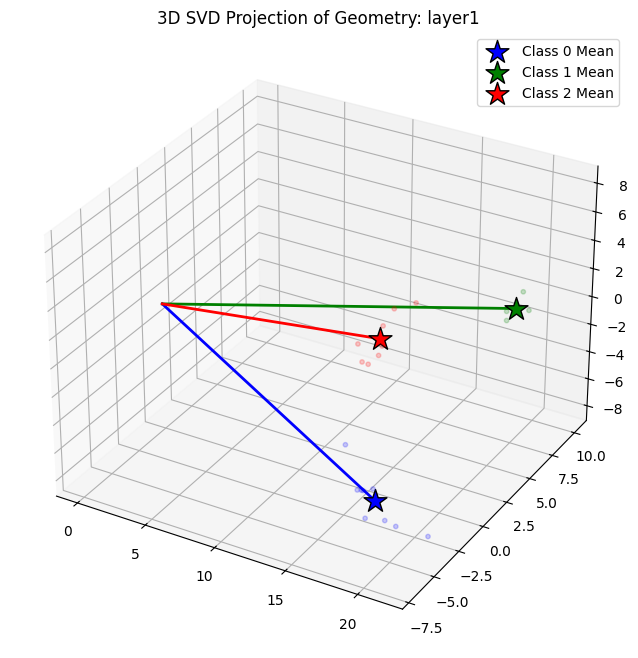

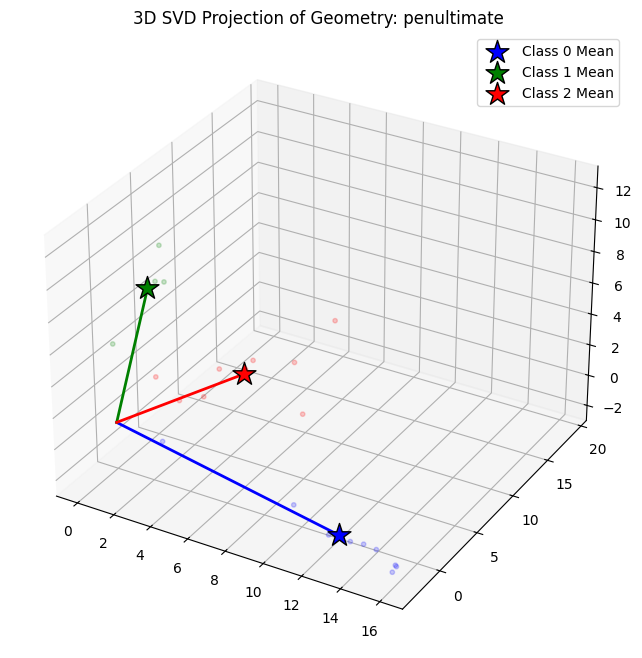

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD


def plot_3d_svd_geometry(layer_features, layer_labels, target_layer='penultimate', classes_to_plot=[0, 1, 2]):
    """
    Projects features and class means of a specific layer into 3D using SVD.
    Plots a subset of classes to keep the 3D plot readable.
    """
    feat = layer_features[target_layer]
    if len(feat.shape) > 2:
        feat = feat.reshape(feat.shape[0], -1)
        
    # Calculate class means for SVD fitting
    class_means = []
    for c in classes_to_plot:
        mask = (layer_labels == c)
        class_means.append(feat[mask].mean(axis=0))
    mu_c = np.array(class_means)
    
    # Fit SVD solely on the class means to find the subspace they span
    svd = TruncatedSVD(n_components=3)
    svd.fit(mu_c)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    for idx, c in enumerate(classes_to_plot):
        mask = (layer_labels == c)
        class_feats = feat[mask]
    
        subset_feats = class_feats[:50] 
    
        proj_feats = svd.transform(subset_feats)
        proj_mean = svd.transform([class_means[idx]])[0]
    
        ax.scatter(proj_feats[:, 0], proj_feats[:, 1], proj_feats[:, 2], 
                   color=colors[idx], alpha=0.2, s=10)
        ax.scatter(proj_mean[0], proj_mean[1], proj_mean[2], 
                   color=colors[idx], marker='*', s=300, edgecolor='black', label=f'Class {c} Mean')
        
        ax.plot([0, proj_mean[0]], [0, proj_mean[1]], [0, proj_mean[2]], color=colors[idx], linewidth=2)

    ax.set_title(f"3D SVD Projection of Geometry: {target_layer}")
    ax.legend()
    plt.show()


plot_3d_svd_geometry(layer_features, layer_labels, target_layer='layer1', classes_to_plot=[0, 1, 2])
plot_3d_svd_geometry(layer_features, layer_labels, target_layer='penultimate', classes_to_plot=[0, 1, 2])

## 15. Project Summary

We summarize the training results, Neural Collapse metrics, and the comparative performance of all OOD detection methods.

In [ ]:
print("="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"\n1. Model Training:")
print(f"   - Architecture: ResNet-18")
print(f"   - Dataset: CIFAR-100 (100 classes)")

print(f"\n2. Neural Collapse Analysis:")
print(f"   - NC1 (Variability Collapse): {nc_metrics['NC1']:.6f}")
print(f"   - NC2 (ETF Convergence): {nc_metrics['NC2']:.6f}")
print(f"   - NC3 (Self-Duality): {nc_metrics['NC3']:.6f}")
print(f"   - NC4 (Nearest Center): {nc_metrics['NC4']:.6f}")

print(f"\n3. OOD Detection Performance (CIFAR-10 as OOD):")
print(results_df.to_string(index=False))

print(f"\n4. Key Findings:")
print(f"   - Best AUROC: {results_df['AUROC'].max():.4f} ({results_df.loc[results_df['AUROC'].idxmax(), 'Method']})")
print(f"   - Best FPR@95%TPR: {results_df['FPR@95%TPR'].min():.4f} ({results_df.loc[results_df['FPR@95%TPR'].idxmin(), 'Method']})")
print(f"   - NECO shows competitive performance leveraging Neural Collapse properties")

print("\n5. Neural Collapse Across Layers:")
for layer, nc1 in layer_nc1.items():
    print(f"   - {layer}: NC1 = {nc1:.6f}")

print("\n" + "="*60)